In [1]:
cd "drive/MyDrive/model_inversion_lenet_svhn"

/content/drive/MyDrive/model_inversion_lenet_svhn


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Extractor(nn.Module):

    def __init__(self, channel=3):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(channel, 6, 5),
            nn.AvgPool2d(2, 2),
            nn.Sigmoid(),
            nn.Conv2d(6, 16, 5),
            nn.AvgPool2d(2, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.extractor(x)
        return x

    
class Classifier(nn.Module):

    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(10, 10)
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100 + 10, 512, 2, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, 2, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 2, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 16, 2, 1, 0, bias=False),
            nn.Sigmoid(),
        )
        self.apply(weights_init)

    def forward(self, z, y):
        y = self.embedding(y)
        y = y.unsqueeze(-1).unsqueeze(-1)
        feat = torch.cat([z, y], 1)
        feat = self.generator(feat)
        return feat

    
    
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(10, 10)
        self.discriminator = nn.Sequential(
            nn.Conv2d(16 + 10, 128, 2, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 2, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 2, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid(),
        )
        self.apply(weights_init)

    def forward(self, feat, y):
        y = self.embedding(y)
        y = y.unsqueeze(-1).unsqueeze(-1)
        y = y.expand(y.size(0), 10, 5, 5)
        feat = torch.cat([feat, y], 1)
        feat = self.discriminator(feat)
        feat = feat.squeeze(-1).squeeze(-1)
        return feat

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.datasets as datasets
import numpy as np

svhn_transform = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
mnist_transform = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=svhn_transform)
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

size = len(svhn_trainset)
index = np.arange(size)
client_trainset = Subset(svhn_trainset, index[:2000])
server_iid_trainset = Subset(svhn_trainset, index[2000:4000])
server_niid_trainset = Subset(mnist_trainset, index[:2000])

client_trainloader = DataLoader(client_trainset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
server_iid_trainloader = DataLoader(server_iid_trainset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
server_niid_trainloader = DataLoader(server_niid_trainset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [4]:
import matplotlib.pyplot as plt  

def get_params(net, modules):
    params = []
    for module in modules:
        params.append({"params": net[module].parameters()})
    return params

def frozen_net(net, modules, frozen):
    for module in modules:
        for param in net[module].parameters():
            param.requires_grad = not frozen
        if frozen:
            net[module].eval()
        else:
            net[module].train()

def total_variation_loss(image):
    bs, c, h, w = image.size()
    tv_h = torch.pow(image[:,:,1:,:] - image[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(image[:,:,:,1:] - image[:,:,:,:-1], 2).sum()
    return (tv_h + tv_w) / (bs * c * h * w)


def bound_limit(image):
    loss = torch.pow(image - torch.clamp(image, -1, 1), 2).sum()
    return loss

def priori_mean_loss(image, channel_means):
    loss = 0
    for i in range(3):
        loss += torch.pow(torch.mean(image[:,i,:,:]) - channel_means[i], 2)
    return loss

def priori_std_loss(image, channel_stds):
    loss = 0
    for i in range(3):
        loss += torch.pow(torch.std(image[:,i,:,:]) - channel_stds[i], 2)
    return loss

def channel_info(image):
    image_ = image[0]
    image_ = image_.cpu().detach().numpy() 
    for i in range(3):
        channel = image_[i]
        print("[channel:%2d] min:%2.6f, max:%2.6f, mean:%2.6f, std:%2.6f"%(i, np.min(channel), np.max(channel), np.mean(channel), np.std(channel)))


def show_image(image):
    image_ = image[0]  # [bs, 3, 32, 32] -> [3, 32， 32]
    image_ = image_.permute(1, 2, 0)
    image_ = image_.cpu().detach().numpy()
    image_ = (image_+1)/2  # [-1,1] -> [0,1]
    plt.imshow(image_)


def cal_psnr(real_image, inversion_image):
    mse = ((real_image - inversion_image) ** 2).mean()
    mse = mse.cpu().detach().numpy()
    psnr = 10 * np.log10(4/mse)
    return psnr

[channel: 0] min:-0.921569, max:0.992157, mean:0.118873, std:0.590455
[channel: 1] min:-0.490196, max:1.000000, mean:0.481587, std:0.394913
[channel: 2] min:0.152941, max:1.000000, mean:0.836290, std:0.156552
[label]  3


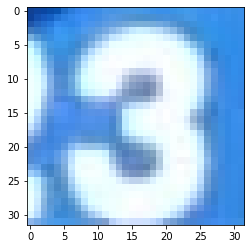

In [5]:
net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

iteration = iter(client_trainloader)

# 图片和标签（全局变量，不要覆盖）
for i in range(4):
    image, label = next(iteration)


# 真实特征（全局变量，不要覆盖）
real_feature = net["extractor"](image).detach()

channel_info(image)
show_image(image)
print("[label] %2d"%label.item())

In [47]:
import torch.optim as optim
import copy


class AvgMeterDict():

    def __init__(self, keys):
        self.keys = keys
        self.vals = {}
        self.ns = {}
        self.reset()

    def reset(self):
        for key in self.keys:
            self.vals[key] = 0.
            self.ns[key] = 0

    def update(self, info):
        for key,val in info.items():
            self.vals[key] += val.item()
            self.ns[key] += 1

    def get(self):
        res = {}
        for key in self.keys:
            res[key] = self.vals[key] / self.ns[key]
        return res


def model_inversion(net, feature, lambda_tv):
    # x = torch.normal(0, 0.1, size=(1, 3, 32, 32))
    x = torch.zeros((1, 3, 32, 32))
    x.requires_grad = True
    x_optimizer = optim.Adam(params=[x], lr=1e-5)

    meter = AvgMeterDict(["feature_mse", "tv_loss", "image_mse"])
    best_epoch, best_metric = -1, 4.
    best_x = None
    epoch = 0
    converge_flag = False

    while True:
        x_optimizer.zero_grad()

        inversion_feature = net["extractor"](x)
        feature_mse = torch.pow(feature - inversion_feature, 2).sum()
        tv_loss = lambda_tv * total_variation_loss(x)
        with torch.no_grad():
            image_mse = torch.pow(image - x, 2).mean()

        loss = feature_mse + tv_loss
        loss.backward()
        x_optimizer.step()

        meter.update({"feature_mse":feature_mse, "tv_loss":tv_loss, "image_mse":image_mse})

        if epoch%1000 == 0:
            res = meter.get()
            print("epoch:%4d, feature_mse:%2.6f, tv_loss:%2.6f, image_mse:%2.6f"
                %(epoch, res["feature_mse"], res["tv_loss"], res["image_mse"]))
            
            if res["image_mse"] < best_metric:
                best_metric = res["image_mse"]
                best_epoch = epoch
                best_x = copy.deepcopy(x)
            elif epoch >= best_epoch + 5000:
                converge_flag = True

            meter.reset()

        if converge_flag:
            break
        epoch += 1
    
    # 返回反推的图片
    return best_x

epoch:   0, feature_mse:82.846146, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:75.398025, tv_loss:0.135773, image_mse:0.489950
epoch:2000, feature_mse:62.823704, tv_loss:0.647835, image_mse:0.487219
epoch:3000, feature_mse:52.868235, tv_loss:1.312174, image_mse:0.485172
epoch:4000, feature_mse:44.706939, tv_loss:2.027063, image_mse:0.483728
epoch:5000, feature_mse:37.934918, tv_loss:2.737524, image_mse:0.482760
epoch:6000, feature_mse:32.352339, tv_loss:3.408562, image_mse:0.482059
epoch:7000, feature_mse:27.787655, tv_loss:4.026965, image_mse:0.481349
epoch:8000, feature_mse:24.052482, tv_loss:4.594018, image_mse:0.480335
epoch:9000, feature_mse:20.985723, tv_loss:5.111280, image_mse:0.478900
epoch:10000, feature_mse:18.481433, tv_loss:5.572821, image_mse:0.477218
epoch:11000, feature_mse:16.461552, tv_loss:5.975415, image_mse:0.475581
epoch:12000, feature_mse:14.842673, tv_loss:6.324599, image_mse:0.474160
epoch:13000, feature_mse:13.536599, tv_loss:6.636123, image_m

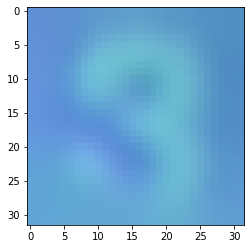

In [49]:
net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_same_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, real_feature, 1e4)
psnr = cal_psnr(image, x)

channel_info(x)
print("psnr:%2.6f"%(psnr))
show_image(x)

epoch:   0, feature_mse:117.283096, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:114.178381, tv_loss:0.084499, image_mse:0.491589
epoch:2000, feature_mse:108.423128, tv_loss:0.396843, image_mse:0.491126
epoch:3000, feature_mse:103.248256, tv_loss:0.820282, image_mse:0.490256
epoch:4000, feature_mse:98.595519, tv_loss:1.289861, image_mse:0.489260
epoch:5000, feature_mse:94.409371, tv_loss:1.777120, image_mse:0.488252
epoch:6000, feature_mse:90.637586, tv_loss:2.271789, image_mse:0.487293
epoch:7000, feature_mse:87.237442, tv_loss:2.768922, image_mse:0.486427
epoch:8000, feature_mse:84.177664, tv_loss:3.255319, image_mse:0.485689
epoch:9000, feature_mse:81.430186, tv_loss:3.715961, image_mse:0.485130
epoch:10000, feature_mse:78.971028, tv_loss:4.134340, image_mse:0.484790
epoch:11000, feature_mse:76.777305, tv_loss:4.492653, image_mse:0.484651
epoch:12000, feature_mse:74.819537, tv_loss:4.782788, image_mse:0.484670
epoch:13000, feature_mse:73.065548, tv_loss:5.008974, ima

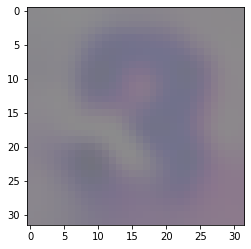

In [48]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_iid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, real_feature, 1e4)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("psnr:%2.6f"%(psnr))
show_image(x)

epoch:   0, feature_mse:156.095734, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:155.453582, tv_loss:0.000000, image_mse:0.489937
epoch:2000, feature_mse:154.104732, tv_loss:0.000000, image_mse:0.486686
epoch:3000, feature_mse:152.637583, tv_loss:0.000000, image_mse:0.483398
epoch:4000, feature_mse:151.047180, tv_loss:0.000000, image_mse:0.480259
epoch:5000, feature_mse:149.350028, tv_loss:0.000000, image_mse:0.477387
epoch:6000, feature_mse:147.570224, tv_loss:0.000000, image_mse:0.474799
epoch:7000, feature_mse:145.740948, tv_loss:0.000000, image_mse:0.472528
epoch:8000, feature_mse:143.897976, tv_loss:0.000000, image_mse:0.470564
epoch:9000, feature_mse:142.071084, tv_loss:0.000000, image_mse:0.468877
epoch:10000, feature_mse:140.279113, tv_loss:0.000000, image_mse:0.467426
epoch:11000, feature_mse:138.531072, tv_loss:0.000000, image_mse:0.466217
epoch:12000, feature_mse:136.832859, tv_loss:0.000000, image_mse:0.465231
epoch:13000, feature_mse:135.188652, tv_loss:0.0

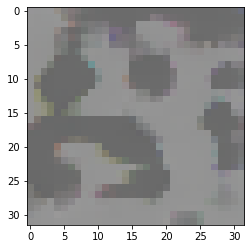

In [53]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_niid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, real_feature, 0)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("psnr:%2.6f"%(psnr))
show_image(x)

epoch:   0, feature_mse:82.576515, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:82.560478, tv_loss:0.000000, image_mse:0.489826
epoch:2000, feature_mse:82.528465, tv_loss:0.000000, image_mse:0.486587
epoch:3000, feature_mse:82.496492, tv_loss:0.000000, image_mse:0.483538
epoch:4000, feature_mse:82.464556, tv_loss:0.000000, image_mse:0.480678
epoch:5000, feature_mse:82.432658, tv_loss:0.000000, image_mse:0.478025
epoch:6000, feature_mse:82.400797, tv_loss:0.000000, image_mse:0.475583
epoch:7000, feature_mse:82.368973, tv_loss:0.000000, image_mse:0.473353
epoch:8000, feature_mse:82.337189, tv_loss:0.000000, image_mse:0.471334
epoch:9000, feature_mse:82.305444, tv_loss:0.000000, image_mse:0.469526
epoch:10000, feature_mse:82.273740, tv_loss:0.000000, image_mse:0.467928
epoch:11000, feature_mse:82.242078, tv_loss:0.000000, image_mse:0.466536
epoch:12000, feature_mse:82.210459, tv_loss:0.000000, image_mse:0.465352
epoch:13000, feature_mse:82.178884, tv_loss:0.000000, image_m

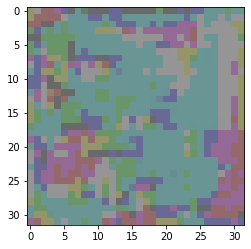

In [55]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)


x = model_inversion(net, real_feature, 0)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("image_mse:%2.6f, psnr:%2.6f"%(image_mse, psnr))
show_image(x)

In [57]:
# z 和 image 配对 (最小化fake feature和real feature的mse)

net = nn.ModuleDict()
net["generator"] = Generator()            
frozen_net(net, ["generator"], True)

G_checkpoint = torch.load("./checkpoint/client_generator.pkl", map_location=torch.device('cpu'))
net["generator"].load_state_dict(G_checkpoint)

# 优化z
z = torch.zeros((1, 100, 1, 1))
z.requires_grad = True
z_optimizer = optim.Adam(params=[z], lr=1e-2)

feature_mses = []
epoch, prev_loss = 0, 10000.
converge_flag = False
while True:
    z_optimizer.zero_grad()
    inversion_feature = net["generator"](z, label)
    feature_mse = ((real_feature - inversion_feature) ** 2).sum()
    feature_mse.backward()
    z_optimizer.step()

    feature_mses.append(feature_mse.item())

    if epoch%1000 == 0:
        print("epoch:%4d, feature_mse:%2.6f"%(epoch, np.mean(feature_mses)))
        if prev_loss < np.mean(feature_mses):
            converge_flag = True
        else:
            prev_loss = np.mean(feature_mses)
        feature_mses = []

    if converge_flag:
        break
    epoch += 1

# 最接近真实feature的虚假feature（全局变量，不要覆盖）
fake_feature = net["generator"](z, label).detach()

epoch:   0, feature_mse:101.330772
epoch:1000, feature_mse:9.673566
epoch:2000, feature_mse:4.793662
epoch:3000, feature_mse:3.447341
epoch:4000, feature_mse:2.888316
epoch:5000, feature_mse:2.531535
epoch:6000, feature_mse:2.356728
epoch:7000, feature_mse:2.255730
epoch:8000, feature_mse:2.212637
epoch:9000, feature_mse:2.186451
epoch:10000, feature_mse:2.146124
epoch:11000, feature_mse:2.113484
epoch:12000, feature_mse:2.086153
epoch:13000, feature_mse:2.074830
epoch:14000, feature_mse:2.070419
epoch:15000, feature_mse:2.055908
epoch:16000, feature_mse:2.046290
epoch:17000, feature_mse:2.041591
epoch:18000, feature_mse:2.039451
epoch:19000, feature_mse:2.035088
epoch:20000, feature_mse:2.024851
epoch:21000, feature_mse:2.022547
epoch:22000, feature_mse:2.022242
epoch:23000, feature_mse:2.020879
epoch:24000, feature_mse:2.019410
epoch:25000, feature_mse:2.017961
epoch:26000, feature_mse:2.017372
epoch:27000, feature_mse:2.015996
epoch:28000, feature_mse:2.013826
epoch:29000, feature_m

epoch:   0, feature_mse:79.563499, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:72.412491, tv_loss:0.023360, image_mse:0.489911
epoch:2000, feature_mse:59.914202, tv_loss:0.133991, image_mse:0.486986
epoch:3000, feature_mse:49.743397, tv_loss:0.299232, image_mse:0.484587
epoch:4000, feature_mse:41.400815, tv_loss:0.485910, image_mse:0.482704
epoch:5000, feature_mse:34.500234, tv_loss:0.675901, image_mse:0.481194
epoch:6000, feature_mse:28.759329, tv_loss:0.860887, image_mse:0.479876
epoch:7000, feature_mse:23.961883, tv_loss:1.038949, image_mse:0.478598
epoch:8000, feature_mse:19.954274, tv_loss:1.208725, image_mse:0.477283
epoch:9000, feature_mse:16.660508, tv_loss:1.363278, image_mse:0.475955
epoch:10000, feature_mse:14.020741, tv_loss:1.495553, image_mse:0.474669
epoch:11000, feature_mse:11.918969, tv_loss:1.607821, image_mse:0.473428
epoch:12000, feature_mse:10.219500, tv_loss:1.708023, image_mse:0.472207
epoch:13000, feature_mse:8.819939, tv_loss:1.802417, image_ms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:133000, feature_mse:1.931582, tv_loss:2.047858, image_mse:0.137908
[channel: 0] min:-0.148751, max:0.349902, mean:0.058496, std:0.096917
[channel: 1] min:0.093499, max:0.785209, mean:0.428931, std:0.178501
[channel: 2] min:0.756004, max:1.109162, mean:0.925203, std:0.079373
psnr:14.661023


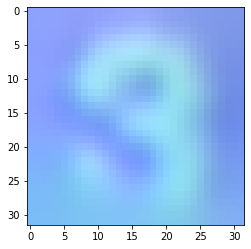

In [65]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, 1e3)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("psnr:%2.6f"%(psnr))
show_image(x)

epoch:   0, feature_mse:81.412674, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:74.158823, tv_loss:0.133169, image_mse:0.490060
epoch:2000, feature_mse:61.941503, tv_loss:0.628471, image_mse:0.487650
epoch:3000, feature_mse:52.278532, tv_loss:1.265524, image_mse:0.485879
epoch:4000, feature_mse:44.355218, tv_loss:1.949213, image_mse:0.484586
epoch:5000, feature_mse:37.783349, tv_loss:2.629687, image_mse:0.483676
epoch:6000, feature_mse:32.372611, tv_loss:3.274059, image_mse:0.482975
epoch:7000, feature_mse:27.952857, tv_loss:3.869334, image_mse:0.482256
epoch:8000, feature_mse:24.338148, tv_loss:4.414863, image_mse:0.481292
epoch:9000, feature_mse:21.371610, tv_loss:4.909281, image_mse:0.479991
epoch:10000, feature_mse:18.948197, tv_loss:5.348778, image_mse:0.478458
epoch:11000, feature_mse:16.990842, tv_loss:5.733518, image_mse:0.476917
epoch:12000, feature_mse:15.419811, tv_loss:6.068574, image_mse:0.475534
epoch:13000, feature_mse:14.150480, tv_loss:6.367438, image_m

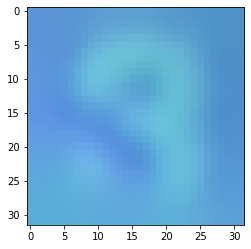

In [68]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_same_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, 1e3)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("psnr:%2.6f"%(psnr))
show_image(x)

epoch:   0, feature_mse:113.710892, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:110.687336, tv_loss:0.080624, image_mse:0.491536
epoch:2000, feature_mse:105.082998, tv_loss:0.378807, image_mse:0.491013
epoch:3000, feature_mse:100.043899, tv_loss:0.780922, image_mse:0.490091
epoch:4000, feature_mse:95.509017, tv_loss:1.231379, image_mse:0.489037
epoch:5000, feature_mse:91.428621, tv_loss:1.702880, image_mse:0.487999
epoch:6000, feature_mse:87.754113, tv_loss:2.183078, image_mse:0.487042
epoch:7000, feature_mse:84.444722, tv_loss:2.664867, image_mse:0.486186
epoch:8000, feature_mse:81.469626, tv_loss:3.133832, image_mse:0.485444
epoch:9000, feature_mse:78.801568, tv_loss:3.574368, image_mse:0.484868
epoch:10000, feature_mse:76.417469, tv_loss:3.967305, image_mse:0.484511
epoch:11000, feature_mse:74.289330, tv_loss:4.299286, image_mse:0.484357
epoch:12000, feature_mse:72.383667, tv_loss:4.569332, image_mse:0.484357
epoch:13000, feature_mse:70.672023, tv_loss:4.780523, ima

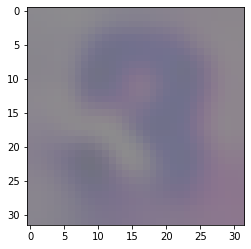

In [71]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_iid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, 1e4)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("psnr:%2.6f"%(psnr))
show_image(x)

epoch:   0, feature_mse:153.464081, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:152.823108, tv_loss:0.000000, image_mse:0.489811
epoch:2000, feature_mse:151.479817, tv_loss:0.000000, image_mse:0.486374
epoch:3000, feature_mse:150.020518, tv_loss:0.000000, image_mse:0.482948
epoch:4000, feature_mse:148.437537, tv_loss:0.000000, image_mse:0.479698
epoch:5000, feature_mse:146.745931, tv_loss:0.000000, image_mse:0.476655
epoch:6000, feature_mse:144.969583, tv_loss:0.000000, image_mse:0.473874
epoch:7000, feature_mse:143.138007, tv_loss:0.000000, image_mse:0.471399
epoch:8000, feature_mse:141.280412, tv_loss:0.000000, image_mse:0.469214
epoch:9000, feature_mse:139.423316, tv_loss:0.000000, image_mse:0.467272
epoch:10000, feature_mse:137.589946, tv_loss:0.000000, image_mse:0.465553
epoch:11000, feature_mse:135.797254, tv_loss:0.000000, image_mse:0.464011
epoch:12000, feature_mse:134.057534, tv_loss:0.000000, image_mse:0.462626
epoch:13000, feature_mse:132.379585, tv_loss:0.0

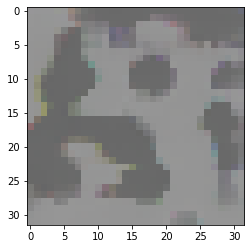

In [72]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_niid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, 0)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("psnr:%2.6f"%(psnr))
show_image(x)

epoch:   0, feature_mse:77.675270, tv_loss:0.000000, image_mse:0.491513
epoch:1000, feature_mse:77.657390, tv_loss:0.000000, image_mse:0.489456
epoch:2000, feature_mse:77.621678, tv_loss:0.000000, image_mse:0.485479
epoch:3000, feature_mse:77.585995, tv_loss:0.000000, image_mse:0.481700
epoch:4000, feature_mse:77.550339, tv_loss:0.000000, image_mse:0.478119
epoch:5000, feature_mse:77.514712, tv_loss:0.000000, image_mse:0.474736
epoch:6000, feature_mse:77.479114, tv_loss:0.000000, image_mse:0.471549
epoch:7000, feature_mse:77.443545, tv_loss:0.000000, image_mse:0.468558
epoch:8000, feature_mse:77.408009, tv_loss:0.000000, image_mse:0.465765
epoch:9000, feature_mse:77.372507, tv_loss:0.000000, image_mse:0.463169
epoch:10000, feature_mse:77.337040, tv_loss:0.000000, image_mse:0.460768
epoch:11000, feature_mse:77.301610, tv_loss:0.000000, image_mse:0.458565
epoch:12000, feature_mse:77.266220, tv_loss:0.000000, image_mse:0.456562
epoch:13000, feature_mse:77.230869, tv_loss:0.000000, image_m

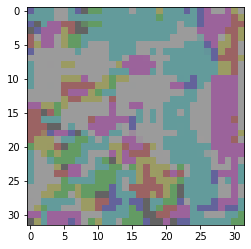

In [73]:


net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)


x = model_inversion(net, fake_feature, 0)
psnr = cal_psnr(image, x)

channel_info(x)
image_mse = torch.pow(image - x, 2).mean()
print("psnr:%2.6f"%(psnr))
show_image(x)